Name : Diane d'Haultfoeuille

# Introduction

This courseworks consists of analysing the dataset from a two photon calcium fluorescence imaging experiment, which was explained in the course : "BE9-MMMB – Mathematical Methods for Bioengineers".

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt # Graphical library
from scipy.signal import correlate

import skel_coursework1  #Load the calcium imaging dataset

# 1.a) Time series and 1.b) Angular position over time

In the dataset description provided in the paper, it is mentioned that the images were captured at a frequency of 30 Hz, equivalent to a sampling period p = 1/f ~ 0.033 seconds. To ensure continuous and smooth curves, I linearized the time variable t by creating a new vector, linear_t, with approximately equal intervals of 0.03 seconds between each time point, ranging from 0 to the size of t.

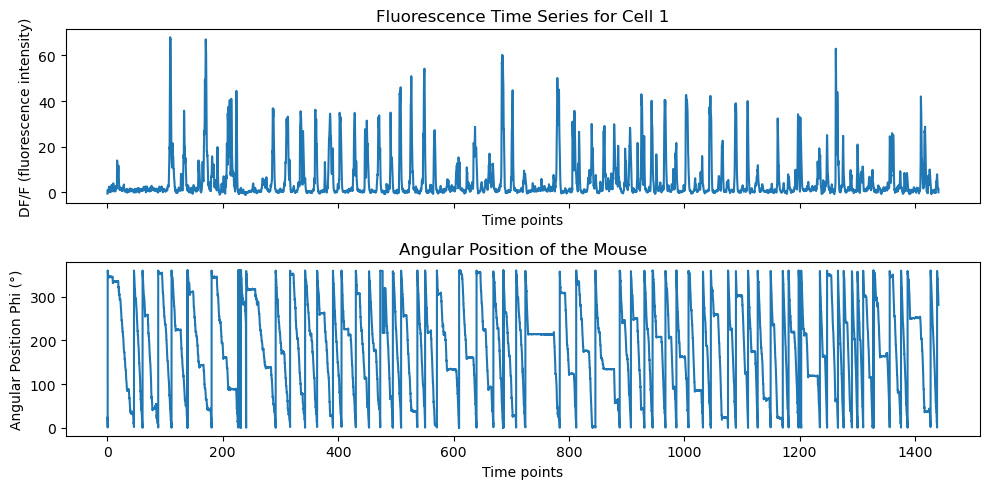

In [ ]:
# Extract variables from skel_coursework1
cell_time_series = skel_coursework1.dfonf[1, :]
phi = skel_coursework1.phi
t = skel_coursework1.t
x = skel_coursework1.x
y = skel_coursework1.y
linear_t = t.flatten()
jump_indice = []

#Find the gaps in vector t
for i in range(len(t)-1):
    time_diff = t.flatten()[i+1] - t.flatten()[i]
    if time_diff < 0:
        jump_indice.append(i)

#Create a new continous vector linear_t
for j in range(len(jump_indice)-1):
    prec_value = linear_t[jump_indice[j]]
    index = jump_indice[j]

    for i in range(jump_indice[j]+1):
        index += 1
        if index == len(linear_t):
            break
        elif (index == jump_indice[j+1]) or (index == (len(linear_t)-1)):
            time_diff = t.flatten()[i] - t.flatten()[i-1]
        else:
            time_diff = t.flatten()[i+1] - t.flatten()[i]
        linear_t[index] = prec_value + time_diff
        prec_value = linear_t[index]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

#Task 1: Subplot for fluorescence time series for cell 1
ax1.plot(linear_t, cell_time_series.flatten())
ax1.set_title(f'Fluorescence Time Series for Cell 1')
ax1.set_xlabel('Time points')
ax1.set_ylabel('DF/F (fluorescence intensity)')

#Task 2: Subplot for angular position
ax2.plot(linear_t, phi.flatten())
ax2.set_title('Angular Position of the Mouse')
ax2.set_xlabel('Time points')
ax2.set_ylabel('Angular Position Phi (°)')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Upon examining fluorescent time series, we can observe multiple peaks, which represent periods of increased activity or firing of the place cells in the mice's brains.
They appear to be at relatively regular intervals from each other, suggesting a form of periodicity. The curve is non-stationary, indicating that neurons are not activated continuously over time.
Finally, there are no outliers, such as abnormal drops, indicating the absence of anomalies in the dataset.

Regarding the plot of the angular position over time, observable regular patterns suggest that the mouse likely moved along a circular and periodic path.

# 1.c) Mouse trajectory

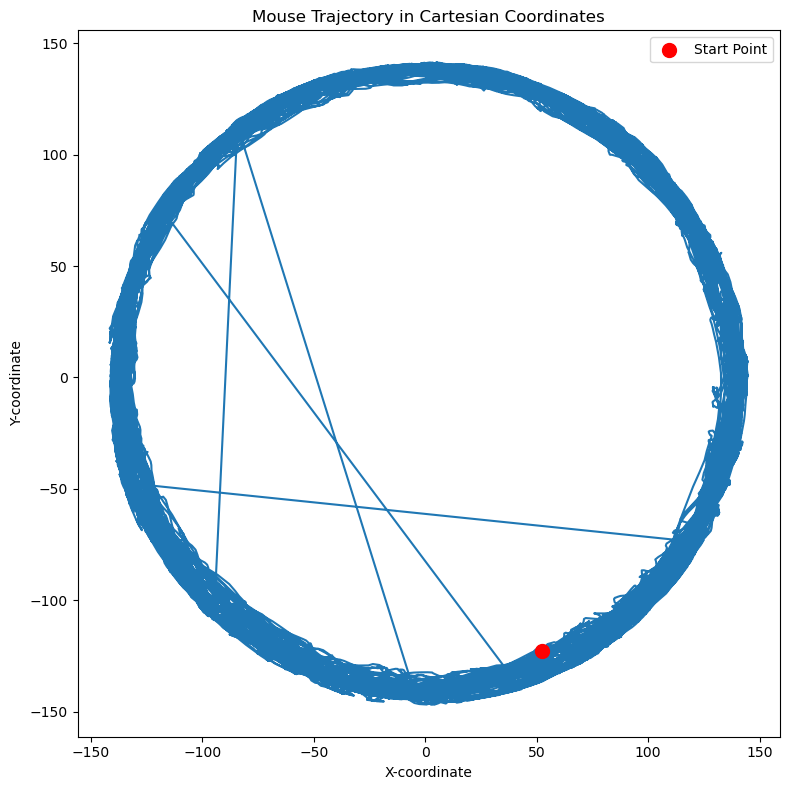

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(x,y)
plt.title('Mouse Trajectory in Cartesian Coordinates')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')

# Highlight the starting point in red
plt.scatter(x[0], y[0], color='red', s=100, marker='o', label='Start Point', zorder=5)
plt.tight_layout()
plt.legend()
plt.show()

The above plot shows that the mice were moving along a circular track and cycle path. As written in the coursework specification, the data were collected by concatenating multiple 4-minute video files collected from the microscope. Each of these is separated by an unknown gap in time – for this reason, the time variable t does not linearly increase but restarts each for each video. This is why we 4 straight lines in the middle of the circle, which are the spatial position jumps at each of these discontinuities.

# 1.d) Average response of this cell at each angular position phi

At first, to find a good way to show the “tuning curve” of the cell’s responses to spatial position (angle), I rounded each value of phi to their nearest integrer and stored them in a new vector rounded_phi. By doing so, I could then average the response contained in the vector cell_time_series (dfonf for cell 1), i.e calculating the average of the corresponding response for each unique rounded value of phi (from 0 to 360°).   

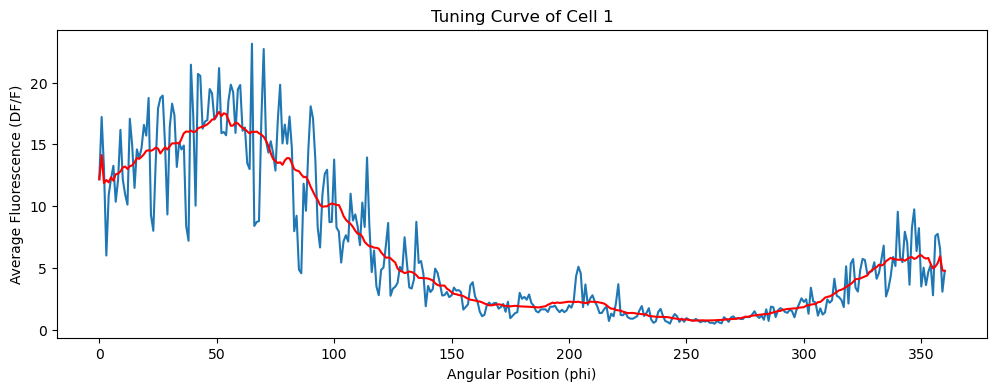

In [ ]:
# Round the values to 2 digits after the decimal point for the vector phi
rounded_phi = np.round(phi, decimals=0)

# Find unique rounded values and their counts
unique_phi, counts = np.unique(rounded_phi, return_counts=True)

average_result = []
average = 0

#Loop on each unique value of phi
for v in range(len(unique_phi)):
    index = np.where(rounded_phi == unique_phi[v])[0]
    if counts[v] > 1:
        tot = 0
        for i in range(len(index)):
            ind = index[i]
            tot += cell_time_series.flatten()[ind]
        average = tot / counts[v]
        average_result.append(average)
    else :
        ind = index[0]
        average_result.append(cell_time_series.flatten()[ind])

#Plot
plt.figure(figsize=(12, 4))
plt.plot(unique_phi,average_result, label=f'Cell 1')
plt.xlabel('Angular Position (phi)')
plt.ylabel('Average Fluorescence (DF/F)')
plt.title(f'Tuning Curve of Cell 1')

#Smooth curve for average_result
WSZ = 25
out0 = np.convolve(average_result,np.ones(WSZ,dtype=int),'valid')/WSZ
r = np.arange(1,WSZ-1,2)
start = np.cumsum(average_result[:WSZ-1])[::2]/r
stop = (np.cumsum(average_result[:-WSZ:-1])[::2]/r)[::-1]
smooth_curve = np.concatenate((start,out0,stop))

plt.plot(unique_phi,smooth_curve,'r')

plt.legend
plt.show()

In the turning curve analysis for cell 1, we can see that the average fluorescence (indicating response of the place cells) are higher for small angular positions (approximately 0 to 125°), while for middle angular position (150° to 300°) the responses are closed to 0.
Notably, the response begins to decline at 50°, and experiences a subsequent increase around 300°.

This curve illustrates the sensitivity of the neuron's activation to the mouse's spatial position. In other words, neurons only become activated in response to a specific location, which is between (-60° to 125°).  

# 2. Produce a delay embedding

To produce a delay embedding, I have to choose an appropriate time lag tau. To do so, it's common to use the "autocorrelation" method seen during the lecture : the first zero of the autocorrelation function is often considered for determining an appropriate time lag. This method provides a good tradeoff between capturing dependencies in the system and avoiding unnecessary correlations.

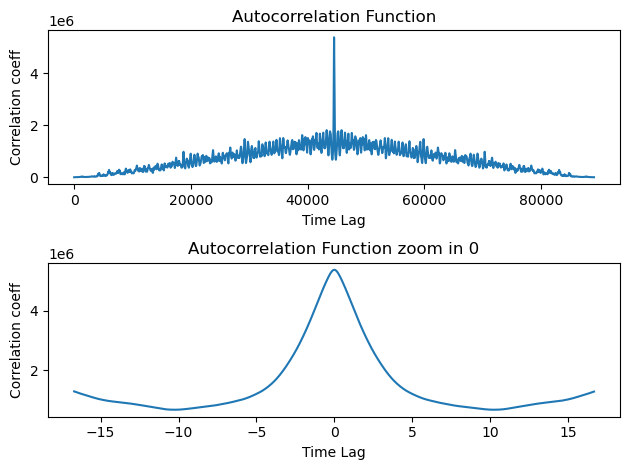

The value of time point for which the correlation coefficient is closest to zero is 10.23.
It corresponds to the value 10.23*0.033 = 0.34 seconds.


In [ ]:
#Choose an optimal time lag with autocorrelation function (acf)
fs = 30 #Hz
width = 501
acg = correlate(cell_time_series.flatten(),cell_time_series.flatten())
center = int(np.floor(np.size(acg)/2))
idx_acg = range(center-width,center+width)
acg_ = acg[idx_acg]
t_acg = np.arange(0-width/fs,0+width/fs,1/fs)

fig, (ax3, ax4) = plt.subplots(2, 1)

ax3.plot(acg)
ax3.set_xlabel('Time Lag')
ax3.set_ylabel('Correlation coeff')
ax3.set_title('Autocorrelation Function')

ax4.plot(t_acg, acg_)
ax4.set_xlabel('Time Lag')
ax4.set_ylabel('Correlation coeff')
ax4.set_title('Autocorrelation Function zoom in 0')

plt.tight_layout()
plt.show()

min_index = np.argmin(np.abs(acg_))

# Get the corresponding value of tau from t_acg
optimal_tp = round(t_acg[min_index], 2)
optimal_tau = round(optimal_tp*0.033, 2)

print(f"The value of time point for which the correlation coefficient is closest to zero is {optimal_tp}.")
print(f"It corresponds to the value {optimal_tp}*0.033 = {optimal_tau} seconds.")

As we can see in the first plot, there is no zero-crossing value when performing the "autocorrelation" method. Then, I choose the time lag value for which the correlation coeff is the closest to 0). The function will return the time point value, and as we know that a time point represents approximately 0.033 sec, we obtain tau = 10.23 * 0.033 = 0.34 sec. To plot the delay embedding figure, I set the variable tau (in time point) to 10.

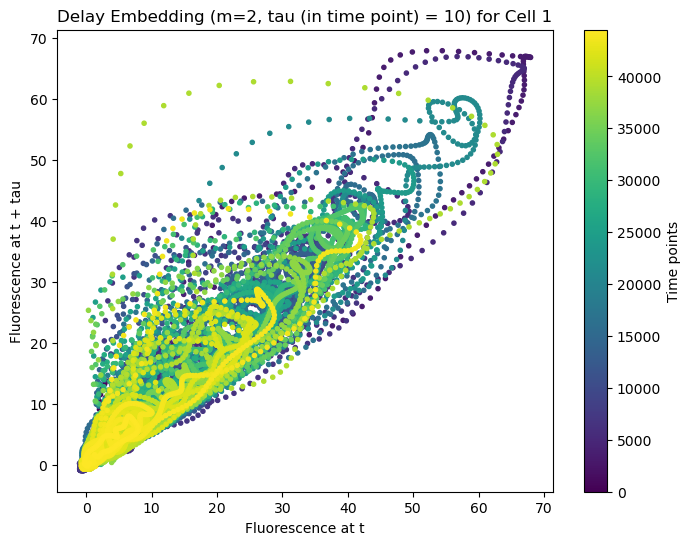

In [ ]:
# Set embedding parameters
m = 2
tau = 10

# Create delay embedding
delay_embedding = np.array([cell_time_series.flatten()[:-2*tau], cell_time_series.flatten()[tau:-tau]])

# Plot the delay embedding
plt.figure(figsize=(8, 6))
plt.scatter(delay_embedding[0], delay_embedding[1], c=range(len(delay_embedding[0])), cmap='viridis', marker='.')
plt.colorbar(label='Time points')
plt.title(f'Delay Embedding (m=2, tau (in time point) = {tau}) for Cell 1')
plt.xlabel('Fluorescence at t')
plt.ylabel(f'Fluorescence at t + tau')
plt.show()

The points of the graph tends to cluster around a diagonal with a slope of 1 (y=x), which means that the fluorescence at time t+tau is proportional to the fluorescence at time t. This suggests that the cell is firing at a constant frequency, which confirms the interpretation made previously on the fluorescent time series (the majority of peaks being separated by equivalent "gaps" time). These could be linked with the assumption that place cells fire when the animal is in a particular location, and thus follow a regular rythm (as the mouse are moving along a circular track and cycle path).

Over time, the fluorenscnce data points become increasingly concentrated towards the 0 value (in the bottom left), which is particularly noticeable with this yellow tip/cluster. This means that the more the time increases, the less is the response of the place cells.  

As described in the paper, the fluorescence is created by a specific protein that bind to calciums ions, so it reflects the concentration of calcium ions within the cell, and by extension the neuronal activity.

# 3. Recurrence plot

There are 4 different plots shown below, in order to determine the optimal value of epsilon to take.

The number of data in the fluorescence time series are too big. Thus, it's impossible to show the recurrence plot because it takes too much memory, as the for loop is O(n^2 /2)), and that would lead to a lifetime run or a crush. Then, we have to extract a sample from the data and make the recurrence plot on it.

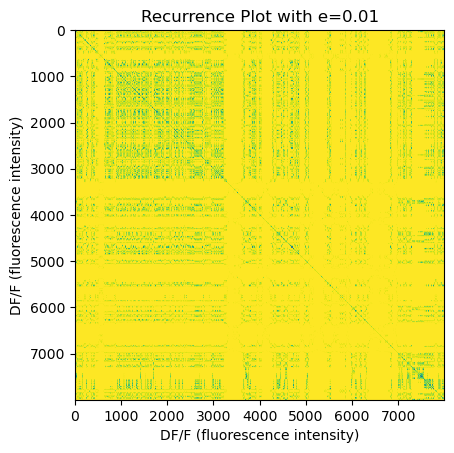

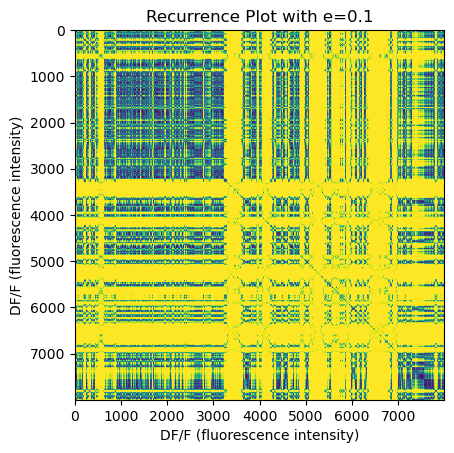

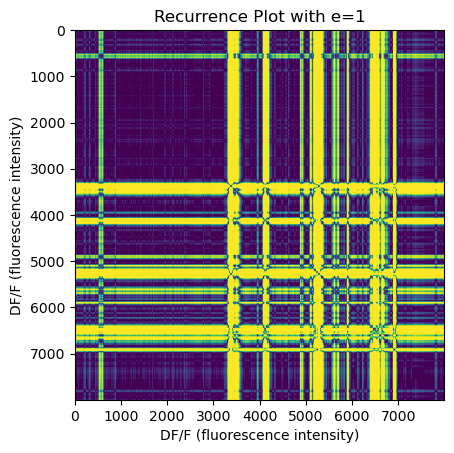

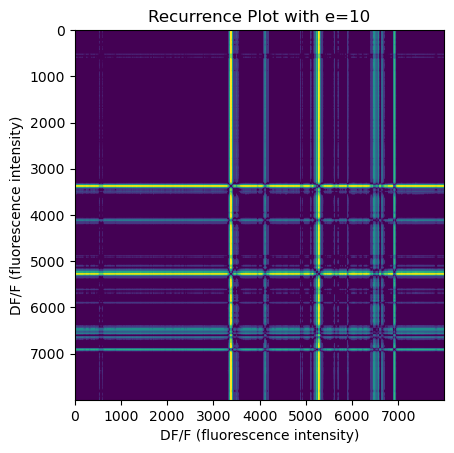

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

#Take a subsample of the data
subsample = 8000
c_t_s_sample = cell_time_series.flatten()[:subsample]
num_points = len(c_t_s_sample)

def rec_plot(data, epsilon, steps=10):
    d = pdist(data[:,None])
    d = np.floor(d/epsilon)
    d[d>steps] = steps
    Z = squareform(d)
    return Z

#Plot the figure
M = [];
epsilon = [0.01, 0.1, 1, 10]

for i in range(4):
    eps = epsilon[i]
    M = rec_plot(c_t_s_sample, eps)
    pos = 441 + i
    plt.figure(pos)
    plt.imshow(M)
    plt.xlabel("DF/F (fluorescence intensity)")
    plt.ylabel("DF/F (fluorescence intensity)")
    plt.title(f"Recurrence Plot with e={epsilon[i]}")

plt.show()

The value epsilon e = 1 seems to be appropriate to see meaningful structure in the data. The recurrence plot is good visualization technique to show how often the fluorescence intensity (i.e neuronal activity) of the cell returns to similar values at different time points.

In this recurrence plot, the pattern shows a clear diagonal line, with some vertical and horizontal yellow bands. The vertical and horizontal yellow lines/clusters show laminar states, which are states that do not change over time.
There is no single isolated point, which means no heavy fluctuations in the system. This suggests that the cell is exhibiting some kind of rhythmic or repetitive activity.

# 4. Activity of the whole population of neurons over time

In order to gain a better understanding of the neural activity plot over time, I created two figures: the first one illustrates all the data points (takes data of every cell throughout the entire duration of the experiment), while the second figure zooms in on the first 100 cells within a time span of 500 seconds.

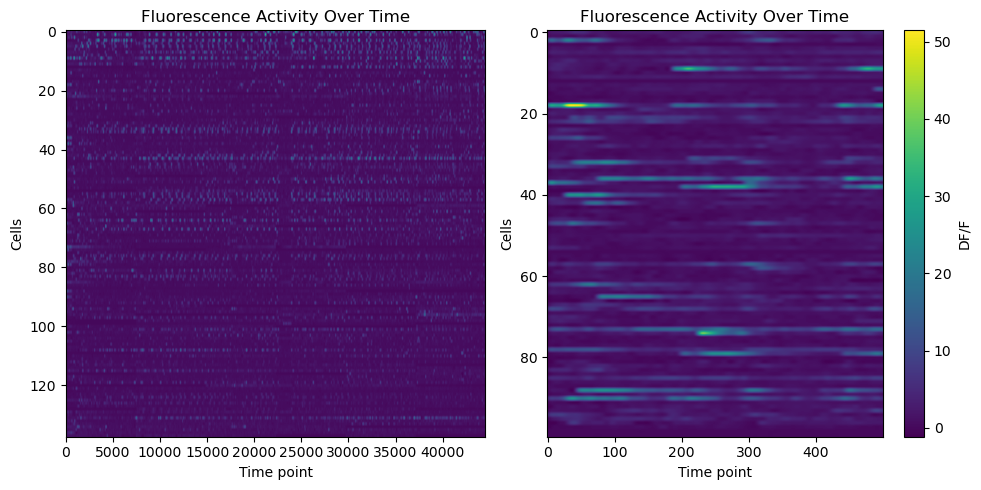

In [ ]:
dfonf = skel_coursework1.dfonf
dfonf2 = skel_coursework1.dfonf[0:100, 0:500]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 3 columns

# Subfigure 1
axs[0].imshow(dfonf, aspect='auto', cmap='viridis')
axs[0].set_title('Fluorescence Activity Over Time')
axs[0].set_xlabel('Time point')
axs[0].set_ylabel('Cells')

# Subfigure 2
im2 = axs[1].imshow(dfonf2, aspect='auto', cmap='viridis')
axs[1].set_title('Fluorescence Activity Over Time')
axs[1].set_xlabel('Time point')
axs[1].set_ylabel('Cells')
fig.colorbar(im2, ax=axs[1], label='DF/F')

plt.tight_layout()
plt.show()


In the figures, we observe multiple yellow points rather than a continuous line, indicating that neuronal activity in not constant over time. The upper part of the first figure has more intenser yellow points. There are several types of more or less intense 'lines' of points on the figure. This becomes clearer in the second figure, where we can see a prominent yellow blurred point in the top left side and lighter blurred lines at specific locations.

The figures reveals that the fluorescence activity of the neurons is not constant over time. There are periods of high activity, followed by periods of low activity. The rate at which the place cells fire action potentials varies depending on the inputs that they are receiving. Also, it points out the specific cells that show responses to the spatial navigation of the mouse.

# 4. Principal Component Analysis (PCA)

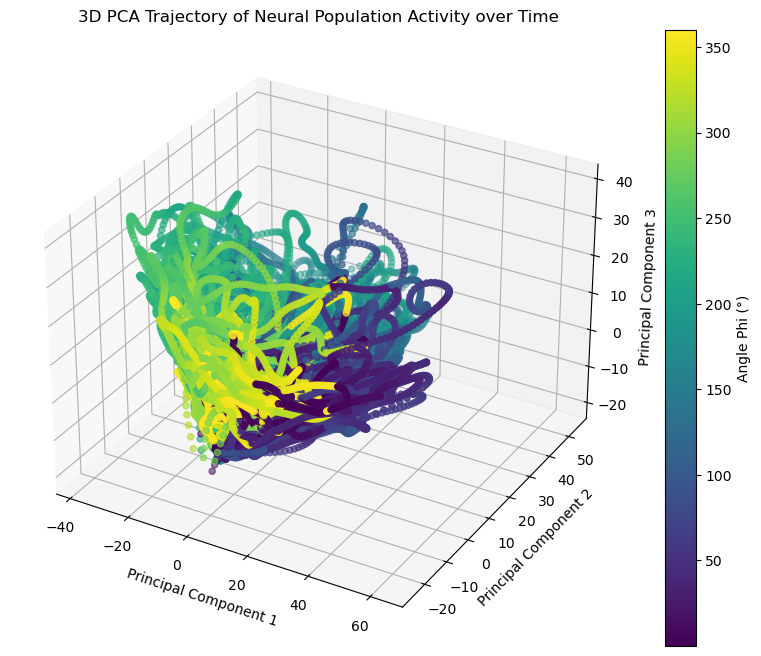

In [ ]:
#Produce a 3-dimensional embedding of the neural population activity
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
embedding = pca.fit_transform(dfonf.T)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the 3-dimensional embedding over time with a color gradient
sc = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=phi, cmap='viridis')

# Add color bar
cbar = fig.colorbar(sc, ax=ax, label='Angle Phi (°)')

# Set labels for axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Set title for the plot
ax.set_title('3D PCA Trajectory of Neural Population Activity over Time')

plt.show()

The 3 principal components are capturing the directions of maximum variance in the data. As the manifold takes the shape of an upward-pointing cone towards the origin (0,0,0), it may be related to the circular nature of the movement of the mouse and the periodic behavior of the place cells.
The colors assigned according to the values of the angular position phi illustrates that the fluorenscence intensity with similar appearances (small variance) are located in corresponding regions of the embedded model.

# References

1. Marwan, N., Romano, M. C., Thiel, M., & Kurths, J. (2007). Recurrence plots for the analysis of complex systems. Physics Reports, 438(5-6), 237-329.